In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, skew
from statsmodels.stats.proportion import proportions_ztest

## Загрузка Данных
Добавим данные и выведем базовую информацию о них. 
Это позволит мне удостовериться, что импортирование прошло успешно и данные не имеют пропусков.

In [209]:
data_df = pd.read_csv('ab_data.csv')
data_df['log_sum_views'] = np.log1p(data_df['sum_views'])  # log1p для обработки нулевых значений. Не стану применять для тестов, но поможет в визуализации далее

display(data_df)
data_df.info()
data_df.describe()

print('\n')
print(data_df.isnull().sum()) # Пропусков нет, не нужно добавлять dropna

,user_id,ab_group,sum_views,retention_1,retention_7,log_sum_views
0,5985237,test,5,False,False,1.791759
1,9721012,ctrl,4,False,False,1.609438
2,4850980,ctrl,13,False,False,2.639057
3,5461771,ctrl,13,False,True,2.639057
4,6689369,ctrl,12,False,False,2.564949
...,...,...,...,...,...,...
105418,5411922,ctrl,25,False,False,3.258097
105419,7862761,ctrl,117,True,True,4.770685
105420,2285458,ctrl,100,True,False,4.615121
105421,5889081,ctrl,1,False,False,0.693147


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105423 entries, 0 to 105422
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        105423 non-null  int64  
 1   ab_group       105423 non-null  object 
 2   sum_views      105423 non-null  int64  
 3   retention_1    105423 non-null  bool   
 4   retention_7    105423 non-null  bool   
 5   log_sum_views  105423 non-null  float64
dtypes: bool(2), float64(1), int64(2), object(1)
memory usage: 3.4+ MB


user_id          0
ab_group         0
sum_views        0
retention_1      0
retention_7      0
log_sum_views    0
dtype: int64


### Проверим Данные на Ошибки

Пропусков нет, но это не означает, что можно начинать анализ. Проверим, что в данных нет странных значений.

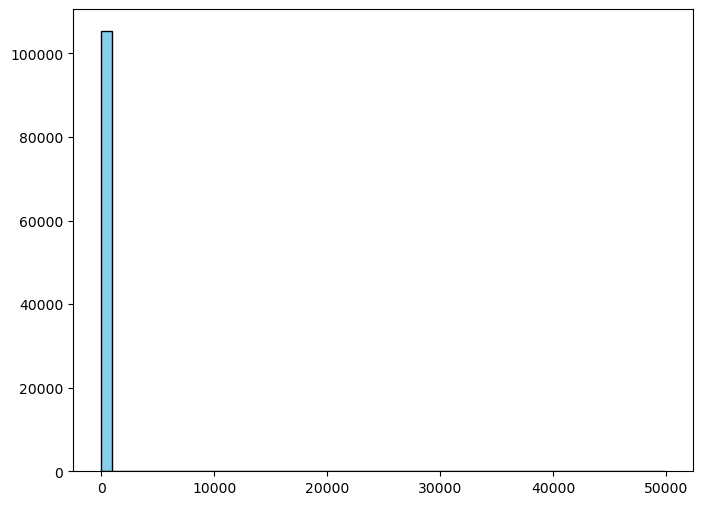

       user_id ab_group  sum_views  retention_1  retention_7  log_sum_views
56335  6390605     ctrl      49854        False         True      10.816874


In [210]:
plt.figure(figsize=(8, 6))
plt.hist(data_df['sum_views'], bins=50, color='skyblue', edgecolor='black')

plt.show()

print(data_df.loc[data_df['sum_views'] > 5000])

В данных найдено одно очень высокое значение (49854 просмотров у юзера 6390605). Так как это очень сильно отличается от других значений, я буду считать, что это значение является ошибочным. Уберем его из данных.

In [211]:
data_df = data_df[data_df['sum_views'] < 5000]

# Начало Анализа

Начнем разбирать наши данные. Я хочу проверить как они распределены, чтобы выбрать правильный тест.

Skewness: 5.88


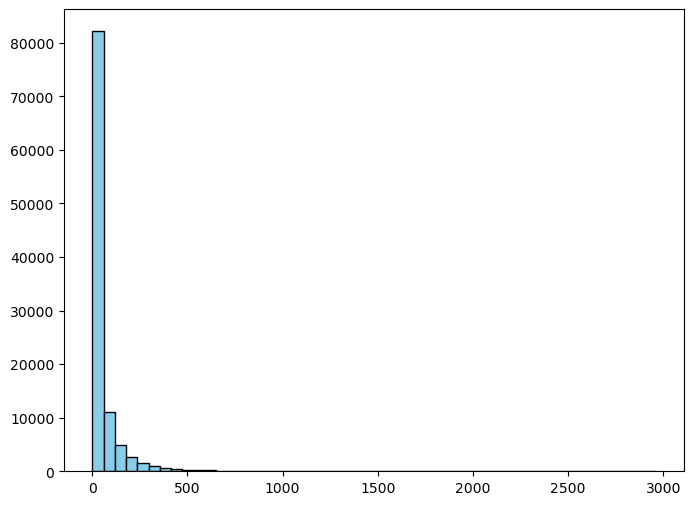

In [212]:
plt.figure(figsize=(8, 6))
plt.hist(data_df['sum_views'], bins=50, color='skyblue', edgecolor='black')
print(f"Skewness: {skew(data_df['sum_views']):.2f}")

По гистограмме и skew мы можем определить, что данные распределены не нормально и имеют большой положительный хвост. t-test не подойдет, будем исползовать тест Манн-Уитни.

In [213]:
control = data_df[data_df['ab_group'] == 'ctrl']
test = data_df[data_df['ab_group'] == 'test']

u_stat, p_value = mannwhitneyu(test['sum_views'], control['sum_views'])
print(f"U-stat: {u_stat:.2f}, P Value: {p_value:.4f}")

print(f"Control Median: {control['sum_views'].median()}, Test Median: {test['sum_views'].median()}")
print(f"Control Mean: {control['sum_views'].mean():.2f}, Test Mean: {test['sum_views'].mean():.2f}")

U-stat: 1353594587.00, P Value: 0.0509
Control Median: 17.0, Test Median: 16.0
Control Mean: 51.28, Test Mean: 51.30


## Результат

P-value на границе нашего уровня значимости в 5%. Медиана и среднее значение двух груп отличается слабо. 
У нас есть несколько опций:
1) Продолжить эксперимент, чтобы набрать больше данных.
2) Признать нулевую гипотезу о том, что медиана просмотренных постов в двух группах не отличается.

Я за второй вариант. Изменения в онбординге не повлияло на колличество просмотренных постов.
Но, у нас есть еще прокси метрики, которые могут повлиять на финальное решение.

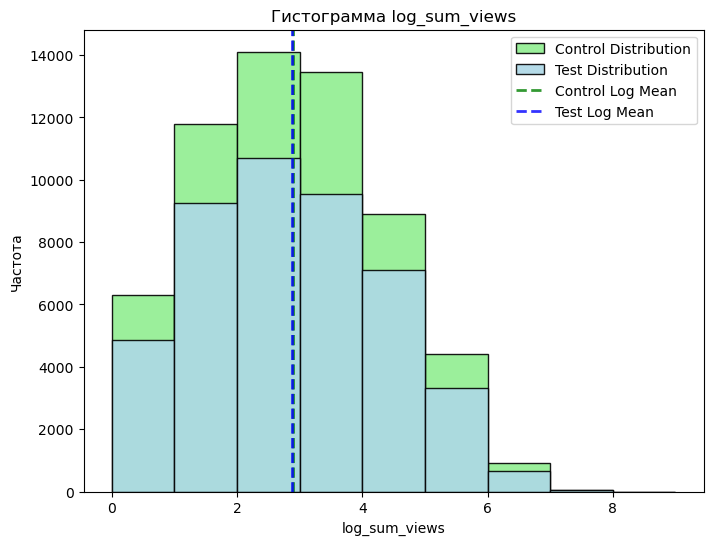

In [214]:
bins = range(0, 10, 1)

plt.figure(figsize=(8, 6))
plt.hist(control['log_sum_views'], bins=bins, color='lightgreen', edgecolor='black', label = 'Control Distribution', alpha=0.9)
plt.hist(test['log_sum_views'], bins=bins, color='lightblue', edgecolor='black', label = 'Test Distribution', alpha=0.9)
plt.axvline(np.mean(control['log_sum_views']), color='green', linestyle='dashed', linewidth=2, label='Control Log Mean', alpha=0.8)
plt.axvline(np.mean(test['log_sum_views']), color='blue', linestyle='dashed', linewidth=2, label='Test Log Mean', alpha=0.8)
plt.title("Гистограмма log_sum_views")
plt.xlabel("log_sum_views")
plt.ylabel("Частота")
plt.legend()
plt.show()

Так как у нас не нормальное распределение данных, давайте взглянем на log. 
Данный график показывает, что распеределение просмотренных постов между двумя группами примерно одинаковое.

### Прокси метрики

Перед принятием решения, давайте посмотрим на другие доступные метрики. Изменение онбординга не способствовало увеличению кол-ва просмотренных постов, но могло улучшить другие показатели.

In [215]:
retention1_control = control['retention_1'].sum()
retention1_test = test['retention_1'].sum()
n_control = control.shape[0]
n_treatment = test.shape[0]
count_retention1 = np.array([retention1_test, retention1_control])
nobs_retention1 = np.array([n_treatment, n_control])
z_stat, p_value = proportions_ztest(count_retention1, nobs_retention1)
print("Retention_1:")
print(f"Control: {retention1_control}/{n_control} ({retention1_control/n_control:.2%})")
print(f"Test: {retention1_test}/{n_treatment} ({retention1_test/n_treatment:.2%})")
print(f"z-statistic={z_stat:.4f}, p-value={p_value:.4f}")

print('\n---\n')

retention7_control = control['retention_7'].sum()
retention7_test = test['retention_7'].sum()
count_retention7 = np.array([retention7_test, retention7_control])
nobs_retention7 = np.array([n_treatment, n_control])
z_stat, p_value = proportions_ztest(count_retention7, nobs_retention7)
print("Retention_7:")
print(f"Control: {retention7_control}/{n_control} ({retention7_control/n_control:.2%})")
print(f"Test: {retention7_test}/{n_treatment} ({retention7_test/n_treatment:.2%})")
print(f"z-statistic={z_stat:.4f}, p-value={p_value:.4f}")

Retention_1:
Control: 26857/59933 (44.81%)
Test: 20119/45489 (44.23%)
z-statistic=-1.8877, p-value=0.0591

---

Retention_7:
Control: 11424/59933 (19.06%)
Test: 8279/45489 (18.20%)
z-statistic=-3.5530, p-value=0.0004


P-value теста на Day 1 Retention опять близко к 5%. Но, как и в прошлый раз, я приму нулевую гипотезу. Изменение онбординга не повлияло на эту метрику. 

Однако, тест Day 7 Retenion показал интересный результат. P-value значительно меньше нашего %% уровня значимости, а это значит, что между группами скорее всего есть разница. Но, наша Z статистика отрицательна, а это значит, что retention тестовой группы ниже, чем у контрольной группы. 

## Вердикт

На данный момент мы имеем следующие данные:
1) Тест на медиану просмотренных постов находится на грани. Но среднии значения и медианы двух групп близки. 
2) Тест на Day 1 Retention показал, что между группами нет значимой разницы.
3) Тест на Day 7 Retention показал, что тестовая группа возвращается реже, чем контрольная. 

#### Моя рекомендация:
Оставить старый онбординг. Я не обнаружил значительных положительных результатов. А Day 7 Retention и вовсе упал. 

### Дополнительные метрики
- Конверсия рекламы (клики)
- Пути прохождения онбординга - где юзеры отпадают
- Время, проведённое в приложении